<a href="https://colab.research.google.com/github/tlemagueresse/benchmarks/blob/master/Times_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark of Machine learning methods : anomaly detection in time series data
Benchmark of unsupervised anomaly detection algorithms based on Machine Learning 
        
Based on the The Numenta Anomaly Benchmark dataset found here : https://github.com/numenta/NAB/blob/master/data/realKnownCause/machine_temperature_system_failure.csv

Related paper : https://www.sciencedirect.com/science/article/pii/S0925231217309864

Description of the data : "Temperature sensor data of an internal component of a large, industrial machine. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine."

Documentation/ Reference :
*   K means : http://amid.fish/anomaly-detection-with-k-means-clustering
*   Autoencoder : http://philipperemy.github.io/anomaly-detection/
*   Isolation forest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
  
@author: Thibaut Le Magueresse - 12/06/2020

# External modules 

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import keras
from tensorflow.keras import layers
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


# Raw data

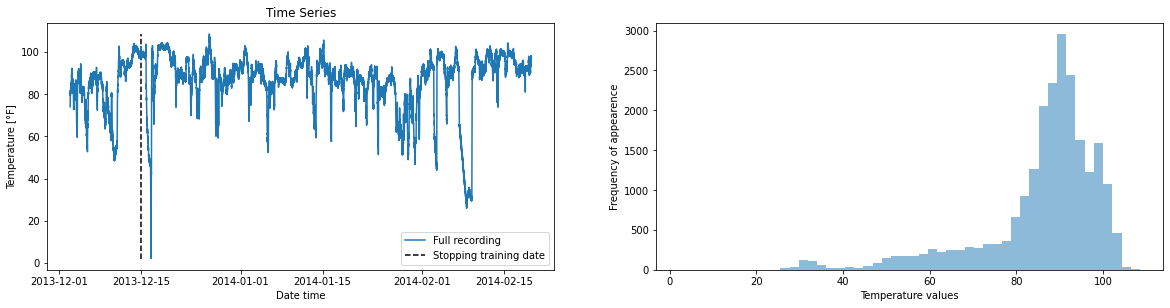

Total duration of signal :  78 days 18:10:00
Training duration :  12 days 02:45:00


In [0]:

url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv'
df = pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp')
stopping_training_date = '2013-12-15 00:00:00'
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(df,label='Full recording')
plt.vlines(df.index[df.index==stopping_training_date][0], min(df.value), max(df.value), linestyles='dashed',label='Stopping training date')
plt.xlabel('Date time')
plt.ylabel('Temperature [°F]')
plt.legend()
plt.title('Time Series')

plt.subplot(222)
plt.hist(df.value, bins = 50, alpha=0.5)
plt.xlabel('Temperature values')
plt.ylabel('Frequency of appearence')
plt.show()

print('Total duration of signal : ', df.index[-1] - df.index[0])
print('Training duration : ', df.index[df.index  == stopping_training_date][0] - df.index[0])

The signal of interest has been recorded by a thermometer placed inside the machine. The goal is to find anomalies of the machine by analyzing this signal. At the end of this notebook, results obtained by unsupervised learning algorithm and ground truth will be compared. 3 algorithms will be studied : K-means, Deep autoecoder and Isolation Forest. The training will be done on the 12 first days of the signal where none anomaly has been detected.

# Data pre-processing



(3490, 1) (19205, 1)


Text(0.5, 0.98, 'Exemples of sequences from training dataset')

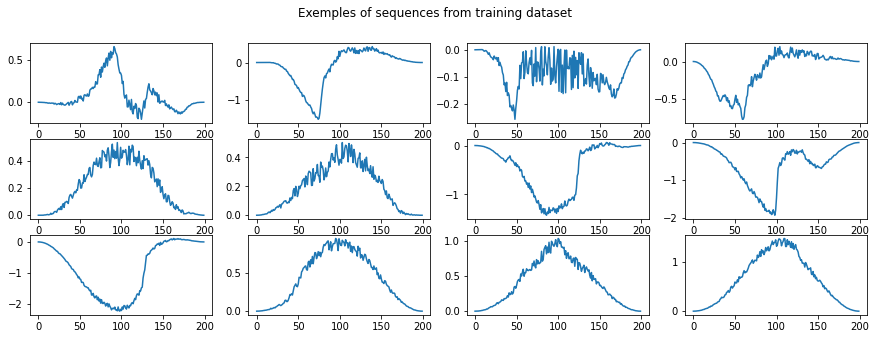

In [0]:
# %% Pre-processing the data : scaling and creation of time sequences
train, test = df.iloc[df.index <= stopping_training_date], df.iloc[df.index > stopping_training_date]
test_size = len(train)
print(train.shape, test.shape)

scaler = StandardScaler().fit(train[['value']])
train_scaled = scaler.transform(train[['value']])
test_scaled = scaler.transform(test[['value']])

def create_dataset(X, slide_len=1, segment_len = 100, windowing = True):
    # Function that create sequences for the Recurrent Network 
    # Overlap of "slide_len" sample
    segments = []
    for start_pos in range(0, len(X), slide_len):
        end_pos = start_pos + segment_len
        segment = np.copy(X[start_pos:end_pos])
        if len(segment) != segment_len:
            continue
        if(windowing): # Very important to avoid side effect
            segments.append(np.hanning(segment_len)[:,np.newaxis] * segment)
        else:
            segments.append(segment)
    return np.squeeze(np.array(segments))

segment_len = 200 # Lenght of the sequence
X_train = create_dataset(train_scaled,segment_len = segment_len)

plt.figure(figsize=(15,5))
for i in range(12): plt.subplot(3,4,i+1),plt.plot(X_train[int(X_train.shape[0]/12)*i,:])
plt.suptitle('Exemples of sequences from training dataset')

#K-means

Text(0.5, 0.98, 'Exemple of basis function from KMeans algorithm')

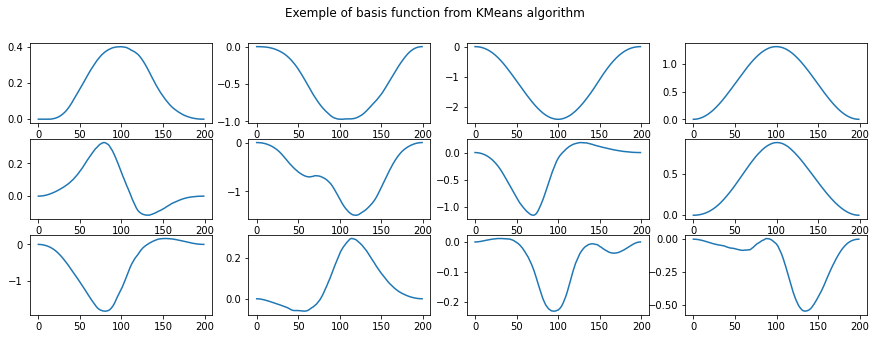

In [0]:
clusterer = KMeans(n_clusters=20)
clusterer.fit(X_train)
centroids = clusterer.cluster_centers_
plt.figure(figsize=(15,5))
for i in range(12): plt.subplot(3,4,i+1),plt.plot(centroids[i,:])
plt.suptitle('Exemple of basis function from KMeans algorithm')


These basis function computed by k-means is an estimation of the strucutre of the signal when the machine is healthy. 
Remark : a wavelet basis functions may be a good idea to explain this data with few functions

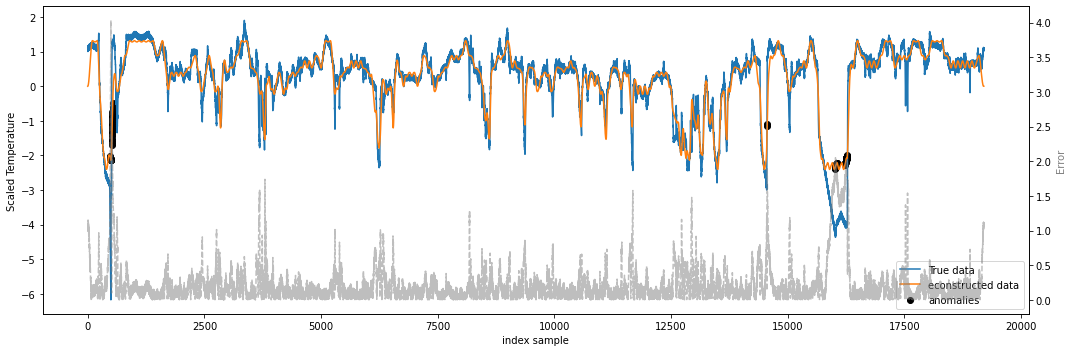

In [0]:
# Prediction of k-means algorithm on the test data
slide_len = int(segment_len / 2) # Overlapp 50%
X_test = create_dataset(test_scaled,slide_len=slide_len ,segment_len = segment_len)


reconstruction = np.zeros(len(test_scaled))
for segment_n in range(X_test.shape[0]):
    seg_tested = np.copy(X_test[segment_n,:])
    nearest_centroid_idx = clusterer.predict(seg_tested[np.newaxis,:])[0]
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * X_test.shape[1]/2)
    if reconstruction[segment_n*slide_len:segment_n*slide_len+segment_len].shape[0] != segment_len:
        continue
    reconstruction[segment_n*slide_len:segment_n*slide_len+segment_len] += nearest_centroid


error = abs(reconstruction - np.squeeze(test_scaled))
threshold = 1.8
indx_anomaly = np.where(error>threshold)[0]

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('index sample')
ax1.set_ylabel('Scaled Temperature')
ax1.plot(test_scaled,  label="True data")
ax1.plot(reconstruction,  label="econstructed data")

ax1.scatter(indx_anomaly,reconstruction[indx_anomaly],color='black',label = 'anomalies')
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.set_ylabel('Error', color=color)  # we already handled the x-label with ax1
ax2.plot(error, color=color,linestyle='dashed' , alpha=0.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Isolation forest

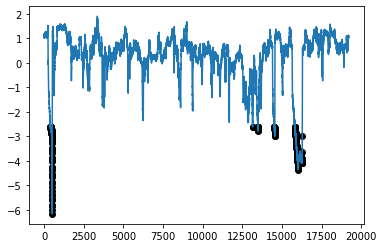

In [0]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.002), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(train_scaled)
pred = clf.predict(test_scaled)
indx_anomaly_isolation=np.where(pred==-1)
plt.figure(figsize=(15,5))
plt.plot(test_scaled)
plt.scatter(indx_anomaly_isolation,test_scaled[indx_anomaly_isolation],color='black',label = 'anomalies')


# LSTM auto-encoder

In [0]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(8, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(8, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model
model = autoencoder_model(X_train_reshaped)
model.compile(optimizer='adam', loss='mae')
model.summary()


Training data shape: (3291, 200)
Test data shape: (191, 200)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 32)             29824     
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 8)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 8)              544       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 32)             5248      
________________________________________________________________

Train on 2961 samples, validate on 330 samples
Epoch 1/40
2961/2961 [==============================] - 2s 580us/step - loss: 0.3130 - val_loss: 0.5979
Epoch 2/40
2961/2961 [==============================] - 0s 136us/step - loss: 0.1909 - val_loss: 0.1291
Epoch 3/40
2961/2961 [==============================] - 0s 141us/step - loss: 0.1345 - val_loss: 0.0751
Epoch 4/40
2961/2961 [==============================] - 0s 137us/step - loss: 0.1235 - val_loss: 0.0527
Epoch 5/40
2961/2961 [==============================] - 0s 136us/step - loss: 0.1030 - val_loss: 0.0636
Epoch 6/40
2961/2961 [==============================] - 0s 135us/step - loss: 0.0926 - val_loss: 0.0503
Epoch 7/40
2961/2961 [==============================] - 0s 136us/step - loss: 0.0874 - val_loss: 0.0434
Epoch 8/40
2961/2961 [==============================] - 0s 139us/step - loss: 0.0806 - val_loss: 0.0386
Epoch 9/40
2961/2961 [==============================] - 0s 142us/step - loss: 0.0739 - val_loss: 0.0471
Epoch 10/40
2961/

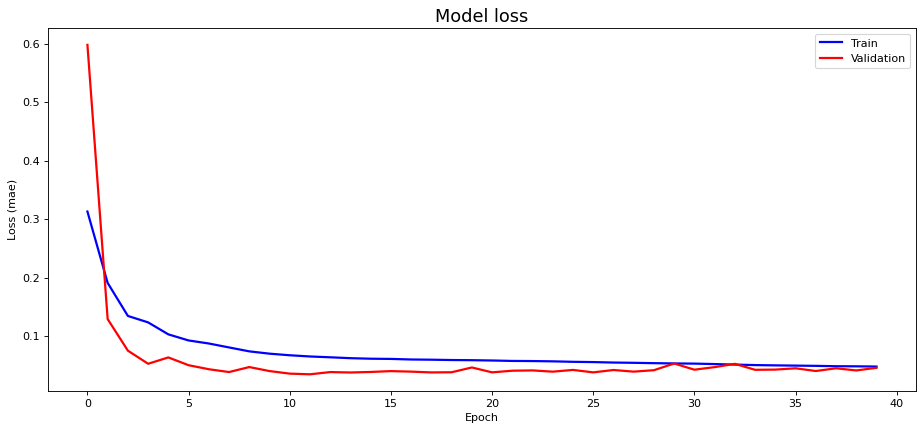

In [0]:
nb_epochs = 40
batch_size = 32
history = model.fit(X_train_reshaped, X_train_reshaped, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


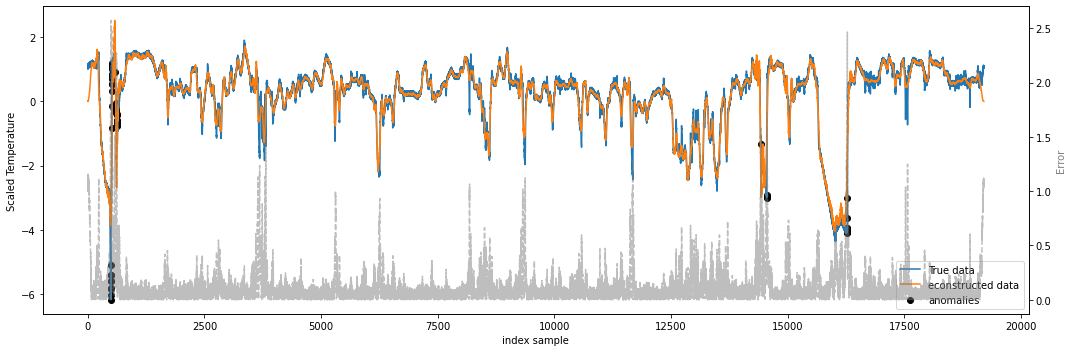

In [0]:
#Prediction
X_pred = model.predict(X_test_reshaped)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])

reconstruction_ae = np.zeros(len(test_scaled))
for segment_n in range(X_test.shape[0]):
    seg_tested = np.copy(X_test[segment_n,:])
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * X_test.shape[1]/2)
    if reconstruction_ae[segment_n*slide_len:segment_n*slide_len+segment_len].shape[0] != segment_len:
        continue
    reconstruction_ae[segment_n*slide_len:segment_n*slide_len+segment_len] += X_pred[segment_n,:]

error = abs(reconstruction_ae - np.squeeze(test_scaled))
threshold = 1.5
indx_anomaly_ae = np.where(error>threshold)[0]

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('index sample')
ax1.set_ylabel('Scaled Temperature')
ax1.plot(test_scaled,  label="True data")
ax1.plot(reconstruction_ae,  label="econstructed data")

ax1.scatter(indx_anomaly_ae,test_scaled[indx_anomaly_ae],color='black',label = 'anomalies')
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.set_ylabel('Error', color=color)  # we already handled the x-label with ax1
ax2.plot(error, color=color,linestyle='dashed' , alpha=0.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Displays and discussion

Text(0, 0.5, 'Scaled Temperature')

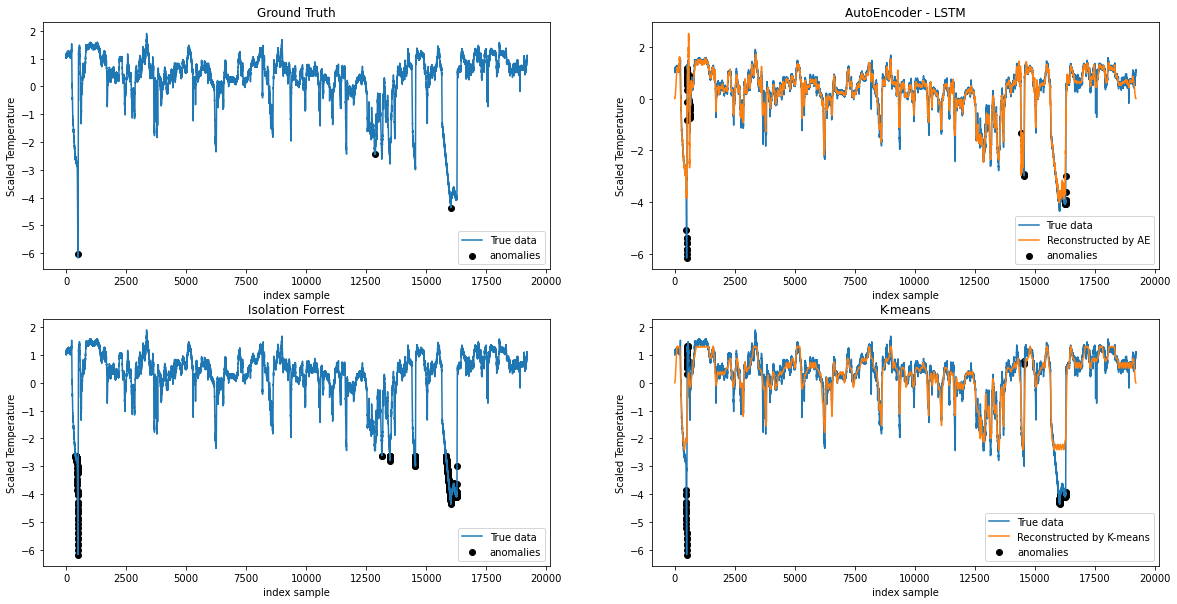

In [0]:
#%% Displays : Synthesis
indx_ground_truth = np.array([495,12853,16025])
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(test_scaled,  label="True data")
plt.scatter(indx_ground_truth,test_scaled[indx_ground_truth],color='black',label = 'anomalies')
plt.title('Ground Truth')
plt.legend()
plt.xlabel('index sample')
plt.ylabel('Scaled Temperature')

plt.subplot(222)
plt.plot(test_scaled,  label="True data")
plt.plot(reconstruction_ae,  label="Reconstructed by AE")
plt.scatter(indx_anomaly_ae,test_scaled[indx_anomaly_ae],color='black',label = 'anomalies')
plt.title('AutoEncoder - LSTM')
plt.legend()
plt.xlabel('index sample')
plt.ylabel('Scaled Temperature')

plt.subplot(223)
plt.plot(test_scaled,  label="True data")
plt.scatter(indx_anomaly_isolation,test_scaled[indx_anomaly_isolation],color='black',label = 'anomalies')
plt.title('Isolation Forrest')
plt.legend()
plt.xlabel('index sample')
plt.ylabel('Scaled Temperature')

plt.subplot(224)
plt.plot(test_scaled,  label="True data")
plt.plot(reconstruction,  label="Reconstructed by K-means")
plt.scatter(indx_anomaly,test_scaled[indx_anomaly],color='black',label = 'anomalies')
plt.title('K-means')
plt.legend()
plt.xlabel('index sample')
plt.ylabel('Scaled Temperature')

Both the first and the last anomalies have been detected. 

The second is more subtile and the studied algorithms are not able to detect it. 

The isolation forest algorithm gives the best results : The first and the last anomalies are early-detected. The influence of the second has been detected also, even if it is a little bit too late. With this algorithm, the damage on the machine (third anomaly) would be avoided.  

We should generate artificial data (by GAN for example) in order to improve the quality of the training of the auto-encoder (improvement of the dynamic range of the error curve; limitation of the false positives)

Personal notes :
Intuition behind K-means and Autoencoder : construct time-basis functions with a reduced dimension and project new time sequences on it. If the prediction is accurate, then the functionning point is normal. If the prediction is far from the real point, then it is an anomaly.

Further Ideas : Projection of sequences over wavelet basis. 
In order to improve AE, applying GAN.